<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [6]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [7]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


Confirm that the data have limited values

Create train/TEST GROUPS USING DataLoader

In [8]:
# Step 1: convert to tensor
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

#Reminder:
# 0) normalize train to [0 1] and test to [0 1]
# 1) normalize train to [0 1] and test to [0 255]
# 2) normalize train to [0 255] and test to [0 1]
train_data=train_data/torch.max(train_data)
test_data=test_data/torch.max(test_data)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [9]:
#check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
batchsize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
labels              ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor           tensor([6, 5, 7,  ..., 2, 9, 5])
matplotlib_inline   module           <module 'matplotlib_inlin<...>tlib_inline/__init__.py'>
nn                  module           <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np                  module           <mo

Create the DL model

In [10]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Create a function that trains the model

In [11]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=60
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

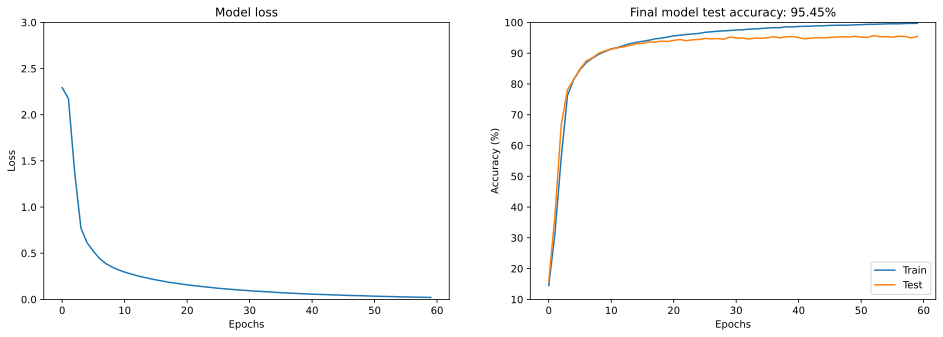

In [12]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

Inspect the results in more detail

In [13]:
X,y=next(iter(test_loader))
predictions=net(X).detach()
predictions

tensor([[-18.6470,  15.1587,  -0.5760,  ...,   5.2364,   1.3366,   0.4687],
        [  0.7986, -11.4448,   2.1391,  ...,  18.2860,  -0.1877,   8.7650],
        [-10.5705,  -5.3836,   5.1323,  ...,  -3.8044,   0.9726,   0.2907],
        ...,
        [ -8.6221,  -5.1376,  -2.9642,  ...,   6.0583,  -5.8482,   5.1888],
        [-15.1023,   4.9039,   2.2162,  ...,   8.9498,   8.9321,  12.1716],
        [-18.0595,  -3.9743, -11.3971,  ...,   4.1117,   6.2726,  23.8998]])

<ipython-input-14-9d383132a6fc>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(range(10),np.exp(predictions[sample2show]))


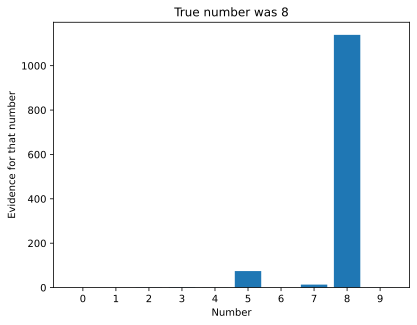

In [14]:
#evidence for all numbers from one sample
sample2show=120
plt.bar(range(10),np.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title("True number was %s"%y[sample2show].item())
plt.show()

<ipython-input-15-605ba88b614e>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


[  59   63   86  125  140  167  185  295  342  344  372  400  414  451
  486  493  530  533  535  603  619  622  647  690  706  763  784  785
  786  824  828  839  841  870  893  927  950  996 1012 1031 1050 1062
 1110 1126 1145 1160 1203 1209 1251 1274 1282 1295 1303 1342 1347 1398
 1411 1425 1430 1443 1453 1486 1487 1515 1523 1538 1549 1553 1560 1576
 1585 1596 1600 1607 1619 1624 1628 1741 1812 1824 1850 1853 1896 1910
 1920 1934 1945 1950 1953 1967 1977]


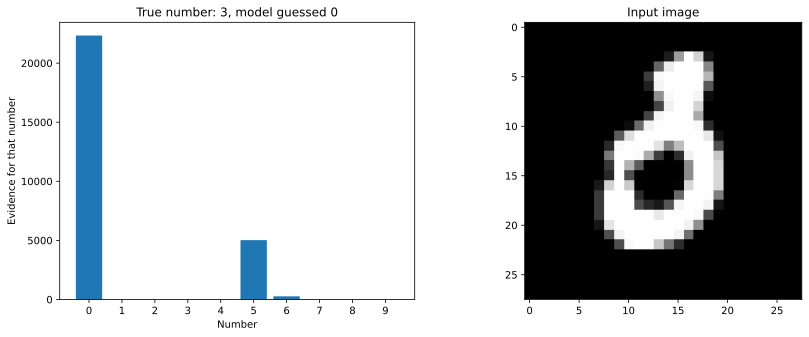

In [15]:
from typing import ChainMap
#find the errors
errors=np.where(torch.argmax(predictions,axis=1)!=y)[0]
print(errors)
#Evidence for all numbers from one sample
sample2show=10
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(),torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show],:],(28,28)),cmap='gray')
ax[1].imshow(X[errors[sample2show]].view(28,28),cmap='gray')
ax[1].set_title('Input image')
plt.show()